# Mitigating Bias with MinDiff Model Remediation

## Learning Objectives
- Learn the concept of equal opportunity fairness.
- Learn how to apply MinDiff method to a TensorFlow model to mitigate bias.

## Introduction
In this notebook, we’ll train a text classifier to identify written content that could be considered toxic or harmful, and apply MinDiff to remediate some fairness concerns. In our workflow, we will:
1.   Train and evaluate our baseline model’s performance on text containing references to sensitive groups.
2.   Improve performance on any underperforming groups by training with MinDiff.
3.   Evaluate the new model’s performance on our chosen metric.

The purpose of this notebook is to demonstrate the usage of the MinDiff technique with a very minimal workflow, not to lay out a principled approach to fairness in machine learning. As such, our evaluation will only focus on one sensitive category and a single metric. We also don’t address potential shortcomings in the dataset, nor tune our configurations in this notebook. 

In a production setting, you would want to approach each of these with rigor. For more information on evaluating for fairness, see [this guide](https://www.tensorflow.org/responsible_ai/fairness_indicators/guide/guidance).


Import all necessary components, including MinDiff in TensorFlow Model Remediation library.

In [1]:
"""
This demonstrates how to suppress TensorFlow and Python warnings.
We set an environment variable to minimize TensorFlow logging output
and also filter out Python warnings. This can help reduce console clutter
while experimenting with code.
"""

import os  # Provides functions for interacting with the operating system
import warnings  # Allows control over warning messages

# Set the TensorFlow C++ minimum log level to "2"
# 0 = all logs shown, 1 = filter out INFO logs, 2 = filter out INFO + WARNING, etc.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Filter out all Python warnings
warnings.filterwarnings("ignore")


In [3]:
# This cell demonstrates how to import various Python libraries commonly used
# in data science, machine learning, and model remediation. Each import is
# briefly explained to help a beginner understand why they might be used.

import copy  # Standard Python library for creating deep or shallow copies of objects.

import numpy as np  # Fundamental package for array computing and numerical operations in Python.
import seaborn as sns  # Statistical data visualization library built on top of matplotlib.
import tensorflow as tf  # Popular open-source library for machine learning and deep learning.
import tensorflow_hub as hub  # Repository for reusable ML modules (often used for transfer learning).
import tensorflow_model_remediation.min_diff as md  # Tools for applying "MinDiff" fairness techniques.

# Utility functions that facilitate MinDiff training in Keras-based TensorFlow models
from tensorflow_model_remediation.tools.tutorials_utils import (
    min_diff_keras_utils,
)


## Prepare Dataset

We use a utility function to download the preprocessed data and prepare the labels to match the model’s output shape. The function also downloads the data as TFRecords to make later evaluation quicker. Alternatively, you may convert the Pandas DataFrame into TFRecords with any available utility conversion function.


In [4]:
# This cell downloads and processes the Civil Comments dataset using the 
# utility function from the min_diff_keras_utils module. The function 
# returns multiple objects, but here we only need the training and validation 
# sets, so we unpack them as data_train and data_validate while ignoring the rest.

(
    data_train,
    data_validate,
    _,
    _,
    _,
) = min_diff_keras_utils.download_and_process_civil_comments_data()


324941336/324941336 [==============================] - 3s 0us/step


Let's take a look at the dataset.

In [5]:
# This cell displays the contents of the data_train variable, which holds
# the training portion of the Civil Comments dataset processed earlier.
data_train


,comment_text,toxicity,gender,sexual_orientation,religion,race,disability
0,Someone should do better homework before they ...,0,[],[],[],[],[]
1,Are you mental? It took so long to extinguish...,0,[],[],[],[],[]
2,I doubt you know enough about international tr...,0,[],[],[],[],[]
3,It's a total disincentive. Love the losers o...,0,[],[],[],[],[]
4,There are other reasons nobody's following thr...,0,[],[],[],[],[]
...,...,...,...,...,...,...,...
1082919,A very good point. ZLB gives you exposure to a...,0,[],[],[],[],[]
1082920,It is clear cut. Right down to the fact that o...,0,[],[],[],[],[]
1082921,Where is the humanity in so many of these comm...,0,[],[],[],[],['psychiatric_or_mental_illness']
1082922,Richard You will make many people happy when ...,0,[],[],[],[],[]


The `comment_text` column has text feature and `toxicity` has the label which represents whether the text is toxic or not (1 or 0).

In [6]:
# This cell filters the training data to only rows where the
# "toxicity" column equals 1, then displays the first five rows.
data_train[data_train["toxicity"] == 1].head()


,comment_text,toxicity,gender,sexual_orientation,religion,race,disability
7,The more Hillary opens her mouth the more she ...,1,['female'],[],[],[],[]
12,"All you ever talk about is trolling, you and y...",1,[],[],[],[],[]
17,"Look, another ignorant, slobbering, mouthbreat...",1,[],[],[],[],[]
18,Comment on the update: It still sucks.,1,[],[],[],[],[]
31,But that men who engage in sex with prostitute...,1,"['male', 'female']",[],[],[],[]


<Axes: xlabel='toxicity', ylabel='Count'>

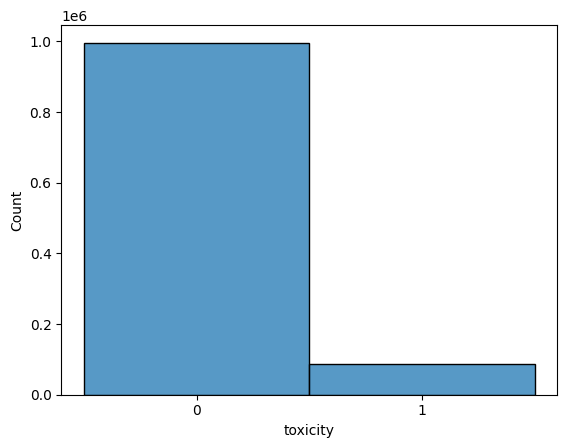

In [7]:
# Create a histogram of the "toxicity" distribution by converting its values to strings.
# This allows Seaborn to treat the toxicity values as discrete categories.
sns.histplot(data_train.toxicity.apply(str))


It looks like the positive (toxic) data is much fewer than the negative (non-toxic) data.

We define a few constants. Note that the batch size here is chosen arbitrarily, but in a production setting you would need to tune it for best performance.

In [8]:
# The name of the text feature column from the dataset
TEXT_FEATURE = "comment_text"

# The target label we want to predict
LABEL = "toxicity"

# The size of the batches we'll use when training
BATCH_SIZE = 512


We convert the training data from pandas dataframe to tf.data, and create a generator that yields a batch.

We also convert our Pandas DataFrames into Tensorflow Datasets.  Note that unlike the Keras model API for Pandas DataFrames, using Datasets means that we need to provide the model’s input features and labels together in one Dataset. Here we provide the `'comment_text'` as an input feature and reshape the label to match the model's expected output.

We batch the Dataset at this stage, too.

In [9]:
# This function converts a pandas DataFrame into a batched TensorFlow Dataset.
# It extracts the text (comment) data and the corresponding toxicity labels,
# and then batches the dataset to the specified size.
def make_dataset(df, batch_size):
    # Convert the DataFrame columns to a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (
            df[TEXT_FEATURE].values,  # Extract the comment text feature
            df[LABEL].values,         # Extract the toxicity label
        )
    ).batch(batch_size)  # Batch the data
    return dataset

# Create the training dataset using the training data
dataset_train_main = make_dataset(data_train, BATCH_SIZE)

# Create the validation dataset using the validation data
dataset_valid_main = make_dataset(data_validate, BATCH_SIZE)


## Define and train the baseline model

Let's define a simple baseline model to classify the text toxicity. It is a simple Keras sequential model with an initial embedding and dense layers, outputting a toxicity prediction. 

In [10]:
# This function builds a simple text classification model using a pre-trained 
# embedding from TensorFlow Hub, followed by two Dense layers.
def build_model():
    hub_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"

    # Create a Sequential model container
    model = tf.keras.Sequential()

    # KerasLayer to load the pre-trained text embedding from TF Hub
    hub_layer = hub.KerasLayer(
        hub_url,
        output_shape=[128],  # Output embedding dimension
        input_shape=[],       # Expect a single string input
        dtype=tf.string       # Data type for text input
    )
    
    # Add the embedding layer to the model
    model.add(hub_layer)
    # Add a fully connected layer with 32 hidden units and ReLU activation
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Final output layer with a single unit and sigmoid activation for binary classification
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    
    return model

# Instantiate the model
baseline_model = build_model()


In [11]:
# Define an optimizer with a learning rate of 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Use binary crossentropy loss, a common choice for binary classification
loss = tf.keras.losses.BinaryCrossentropy()

# Compile the model with the chosen optimizer, loss function, and accuracy metric
baseline_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

# Train the model for 1 epoch on the training dataset
history = baseline_model.fit(
    x=dataset_train_main,      # Training dataset
    batch_size=BATCH_SIZE,     # Batch size
    epochs=1                   # Number of epochs
)


2116/2116 [==============================] - 27s 10ms/step - loss: 0.2466 - accuracy: 0.9205


In [12]:
# Evaluate the trained model on the validation dataset.
valid_result = baseline_model.evaluate(dataset_valid_main)

# The first element of the result is the loss, 
# and the second is the accuracy (since we compiled the model with 'accuracy').
print(f"Validation Accuracy: {valid_result[1]}")


1411/1411 [==============================] - 13s 9ms/step - loss: 0.2315 - accuracy: 0.9218
Validation Accuracy: 0.9217508435249329


## Prepare data splits for MinDiff

To use MinDiff, we create two additional data splits:
* A split for non-toxic examples referencing minority groups: In our case, this will include comments with references to our underperforming identity terms.  We don’t include some of the groups because there are too few examples, leading to higher uncertainty with wide confidence interval ranges.
* A split for non-toxic examples referencing the majority group.

It’s important to have sufficient examples belonging to the underperforming classes. Based on your model architecture, data distribution, and MinDiff configuration, the amount of data needed can vary significantly. In past applications, we have seen MinDiff work well with 5,000 examples in each data split.

In our case, the groups in the minority splits have example quantities of 9,688 and 3,906. Note the class imbalances in the dataset; in practice, this could be cause for concern, but we won’t seek to address them in this notebook since our intention is just to demonstrate MinDiff.  

We select only negative examples for these groups, so that MinDiff can optimize on getting these examples right. It may seem counterintuitive to carve out sets of ground truth *negative* examples if we’re primarily concerned with disparities in *false positive rate (FPR)*, but remember that a false positive prediction is a ground truth negative example that’s incorrectly classified as positive, which is the issue we’re trying to address.

### Create splits with DataFrame

First, let's create the splits using pandas DataFrame.

Note how we define majority and minority in this dataset. And we filter out positive example.

In [13]:
# This function creates MinDiff datasets by identifying sensitive and 
# non-sensitive groups based on the "religion" column, and further 
# filtering on nontoxic examples (toxicity = 0).
def create_mindiff_datasets(df):
    # Create a mask (boolean series) for minority group entries
    # We'll define minority as any row that contains "jewish" or "muslim" in the 'religion' field
    minority_mask = df.religion.apply(
        lambda x: any(religion in x for religion in ("jewish", "muslim"))
    )
    
    # Create a mask for majority group entries
    # We'll define majority as rows where 'religion' == "['christian']"
    majority_mask = df.religion.apply(lambda x: x == "['christian']")

    # Create a mask for nontoxic examples (true negatives for toxicity)
    true_negative_mask = df["toxicity"] == 0

    # Apply the masks to select sensitive nontoxic rows
    data_sensitive = df[minority_mask & true_negative_mask]
    # Apply the masks to select nonsensitive (majority) nontoxic rows
    data_nonsensitive = df[majority_mask & true_negative_mask]
    
    return data_sensitive, data_nonsensitive

# Create MinDiff training datasets for sensitive and nonsensitive groups
data_train_sensitive, data_train_nonsensitive = create_mindiff_datasets(data_train)

# Create MinDiff validation datasets for sensitive and nonsensitive groups
data_valid_sensitive, data_valid_nonsensitive = create_mindiff_datasets(data_validate)


Now we got two DataFrames for majority and minority.

In [14]:
# This cell displays the first few rows of the sensitive subset of the training data.
data_train_sensitive.head()


,comment_text,toxicity,gender,sexual_orientation,religion,race,disability
114,Corresponding with relatives in The Netherland...,0,[],[],['muslim'],[],[]
150,The muslim faith has told the world they\ninte...,0,[],[],['muslim'],[],[]
307,The bitter irony of this anti-settlement narra...,0,[],[],['jewish'],[],[]
358,"re: Baber, the local zealot, angrily walks int...",0,[],[],['muslim'],[],[]
393,Soros is the money source for almost all the m...,0,[],[],['muslim'],[],[]


In [15]:
# This cell displays the first five rows of the nonsensitive subset of the training data.
data_train_nonsensitive.head()


,comment_text,toxicity,gender,sexual_orientation,religion,race,disability
28,It's people like Demboski that give Christians...,0,[],[],['christian'],[],[]
29,Quite a misstatement. The pope shows great ba...,0,[],[],['christian'],[],[]
290,Just more evidence that NCR is the vanguard of...,0,[],[],['christian'],[],[]
300,Fine. Oppose the death penalty all you want. ...,0,[],[],['christian'],[],[]
309,This is not our first trip through your privac...,0,[],[],['christian'],[],[]


### Create MinDiff Datasets

Then, we wrap them in tf.data.Dataset using the `make_dataset` function defined above.

Note that we tune the batch size selection the same way it is tuned for the baseline model, taking into account training speed and hardware considerations while balancing with model performance. Here we have chosen the same batch size for all three datasets but this is not a requirement, although it’s good practice to have the two MinDiff batch sizes be equivalent.

In [16]:
# Here, we create separate TensorFlow Datasets for the sensitive and 
# nonsensitive subsets of our training and validation data. Each subset 
# is batched according to the predefined batch size.

dataset_train_sensitive = make_dataset(data_train_sensitive, BATCH_SIZE)
dataset_train_nonsensitive = make_dataset(data_train_nonsensitive, BATCH_SIZE)
dataset_valid_sensitive = make_dataset(data_valid_sensitive, BATCH_SIZE)
dataset_valid_nonsensitive = make_dataset(data_valid_nonsensitive, BATCH_SIZE)


## Baseline Model Evaluation
### Check the Prediction distribution

Now we have two data splits.

Let's take a look at the prediction distribution for majority (nonsensitive) and minority (sensitive) classes using the baseline model.<br>
Please remember that we only use negative examples, so ideally the predictions should be closer to 0.0.

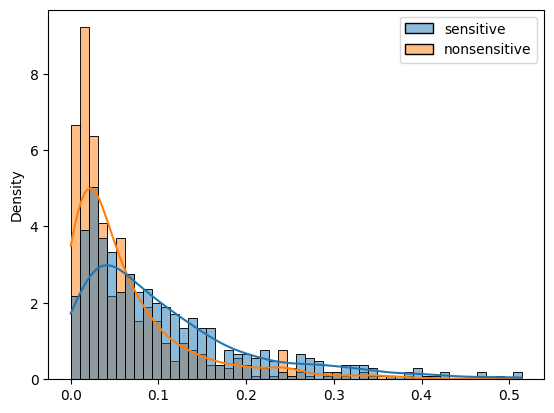

In [17]:
# This function takes a trained model and visualizes its predictions on 
# sensitive vs nonsensitive validation subsets using a histogram.
def visualize_pred_histogram(model):
    # Take one batch of data from each of the sensitive and nonsensitive datasets
    for (f, l), (non_f, non_l) in zip(
        dataset_valid_sensitive.take(1), 
        dataset_valid_nonsensitive.take(1)
    ):
        # Get model predictions for the sensitive batch and squeeze to remove extra dimensions
        res = tf.squeeze(model(f))
        # Get model predictions for the nonsensitive batch
        non_res = tf.squeeze(model(non_f))
        
        # Plot histograms of the two prediction distributions on the same plot
        sns.histplot(
            {"sensitive": res, "nonsensitive": non_res},
            bins=50,        # Number of histogram bins
            kde=True,       # Whether to draw a kernel density estimate
            stat="density", # Normalizes counts so the area under the histogram = 1
        )

# Call the function to visualize predictions of the baseline_model
visualize_pred_histogram(baseline_model)


We can see a distribution difference between splits, and the minority dataset has lower confidence for the negative cases, that will lead to higher false positives.

### Check FPR

In [18]:
# This function calculates the False Positive Rate (FPR) given
# true labels, predicted labels, and a specified threshold.
def false_positive_rate(y_true, y_pred, thresholds):
    # Initialize a FalsePositives metric object with the given thresholds
    fp = tf.keras.metrics.FalsePositives(thresholds=thresholds)
    # Update the state of the metric (count false positives)
    fp.update_state(y_true, y_pred)
    # Retrieve the total number of false positives
    fp = fp.result().numpy()

    # Initialize a TrueNegatives metric object with the same thresholds
    tn = tf.keras.metrics.TrueNegatives(thresholds=thresholds)
    # Update the state of the metric (count true negatives)
    tn.update_state(y_true, y_pred)
    # Retrieve the total number of true negatives
    tn = tn.result().numpy()

    # Calculate FPR = FP / (FP + TN)
    return fp / (fp + tn)


In [19]:
# This function calculates and prints the False Positive Rate (FPR) for both
# the nonsensitive and sensitive subsets of the training data. It uses a
# specified threshold (default is 0.5) to classify predictions as
# positive or negative.
def compute_fpr(model, thresholds=0.5):
    # Get predictions for the nonsensitive group (majority group)
    nonsensitive_prediction = model.predict(
        data_train_nonsensitive[TEXT_FEATURE],  # The feature column for text
        batch_size=BATCH_SIZE,                  # Use the predefined batch size
        verbose=3                               # Verbosity level for logging
    )

    # Get predictions for the sensitive group (minority group)
    sensitive_prediction = model.predict(
        data_train_sensitive[TEXT_FEATURE],
        batch_size=BATCH_SIZE,
        verbose=3
    )

    # Compute FPR for the nonsensitive group
    nonsensitive_fpr = false_positive_rate(
        data_train_nonsensitive[LABEL].values,  # Ground-truth labels
        nonsensitive_prediction,                # Model predictions
        thresholds=thresholds                   # Classification threshold
    )

    # Compute FPR for the sensitive group
    sensitive_fpr = false_positive_rate(
        data_train_sensitive[LABEL].values,
        sensitive_prediction,
        thresholds=thresholds
    )

    # Print the FPR values with some formatting for readability
    print(f"Nonsensitive FPR: {nonsensitive_fpr:>5.5f}")
    print(f"Sensitive FPR:   {sensitive_fpr:>5.5f}")


In [20]:
# Evaluate the baseline_model's false positive rate (FPR) on both 
# sensitive and nonsensitive subsets using a threshold of 0.2.
# A lower threshold means the model is more likely to predict 'positive' (toxic)
# for a given input, thus potentially increasing the FPR.
compute_fpr(baseline_model, thresholds=0.2)


Nonsensitive FPR: 0.06096
Sensitive FPR:    0.15155


We can see the baseline model is performing differently on different splits.

## Define and Train the MinDiff Model

Now, we’ll try to improve the FPR for underperforming religious groups. We’ll attempt to do so using [MinDiff](https://arxiv.org/abs/1910.11779), a remediation technique that seeks to balance error rates across slices of your data by penalizing disparities in performance during training. When we apply MinDiff, model performance may degrade slightly on other slices. As such, our goals with MinDiff will be:
*   Improved performance for underperforming groups
*   Limited degradation for other groups and overall performance



To train with MinDiff, we have to follow these steps:

- Define the model architecture
- Wrap it in a MinDiffModel with a corresponding `loss` and `loss_weight`.  
- Compile the model normally (using the regular non-MinDiff loss) and fit to train. 

For the loss definition, we use 1.5 as the default `loss_weight`, which means how we prioritize the MinDiff loss over the primary cross entropy loss, but this is a parameter that needs to be tuned for your use case, since it depends on your model and product requirements.<br>
You can experiment with changing the value to see how it impacts the model, noting that increasing it pushes the performance of the minority and majority groups closer together but may come with more pronounced tradeoffs.

In [21]:
# Build a new instance of the original model architecture
original_model = build_model()

# Define the MinDiff loss function
min_diff_loss = md.losses.MMDLoss()

# Specify how strongly MinDiff should be weighted relative to the primary task
min_diff_weight = 1.5

# Wrap the original model with MinDiff capabilities
# This allows the model to use the specified MinDiff loss function
# and incorporate it into training to reduce disparity.
min_diff_model = md.keras.MinDiffModel(
    original_model,
    min_diff_loss,
    min_diff_weight
)

# Define an optimizer with a learning rate of 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Use binary crossentropy for the main classification loss
loss = tf.keras.losses.BinaryCrossentropy()

# Compile the MinDiff model with the specified optimizer, loss, and metrics
min_diff_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)


And we also defines the dataset that will be passed to the MinDiffModel during training.

Here we repeat the dataset so that we can train on the same amount as the base model for comparison.

In [22]:
# Create a MinDiff training dataset by packaging the original dataset along with
# the sensitive and nonsensitive group datasets. This allows MinDiff to compute
# additional loss signals that address fairness issues in model predictions.
min_diff_dataset = md.keras.utils.input_utils.pack_min_diff_data(
    original_dataset=dataset_train_main,        # The main training dataset
    sensitive_group_dataset=dataset_train_sensitive,   # Sensitive group subset
    nonsensitive_group_dataset=dataset_train_nonsensitive,  # Nonsensitive group subset
)

# Repeat the MinDiff dataset a certain number of times to ensure we have
# enough examples from the sensitive/nonsensitive groups relative to the
# original dataset. This uses integer division of cardinalities.
min_diff_dataset = min_diff_dataset.repeat(
    int(
        dataset_train_main.cardinality()
        // dataset_train_sensitive.cardinality()
    )
)


Now let's execute the MinDiff training.

In [ ]:
# Train the MinDiff model using the previously created MinDiff dataset.
# This incorporates both the main classification loss and the MinDiff loss
# during training to help reduce group-level disparities.
history = min_diff_model.fit(
    min_diff_dataset,  # The combined MinDiff dataset
    epochs=1           # Number of epochs to train
)


1168/2100 [===============>..............] - ETA: 33s - loss: 0.2659 - accuracy: 0.9161 - min_diff_loss: 0.0020

Next we evaluate the results.  

## MinDiff Model Evaluation

Let's take a look at the result by visualizing the prediction distribution again.

In [ ]:
# Generate a histogram showing the distribution of predictions from the MinDiff model
# on both the sensitive and nonsensitive subsets. This is a visual way to assess
# how well MinDiff addresses disparity in model predictions.
visualize_pred_histogram(min_diff_model)


This looks much better sicce the distributions are closer compared to the baseline model.

Let's check the FPR as we did for the baseline model.

In [ ]:
# Evaluate the MinDiff model's false positive rate (FPR) on both
# sensitive and nonsensitive subsets using a threshold of 0.2.
# This helps us verify if MinDiff successfully reduces group-level disparities.
compute_fpr(min_diff_model, thresholds=0.2)


FPRs for sensitive and nonsensitive datasets are also very close!

In a production setting, we have to pick a threshold to ensure that the model behavior meets launch standards.<br>
This threshold may be different from the one you selected for the baseline model. Try selecting false positive rate with threshold 0.300.

In [ ]:
# Evaluate the MinDiff model's false positive rate (FPR) on both
# sensitive and nonsensitive subsets using a threshold of 0.3.
# Changing the threshold can shift the trade-off between precision and recall.
compute_fpr(min_diff_model, thresholds=0.3)


Copyright 2024 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License